### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... , от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

import warnings

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_w=data.resample('W').sum()
data_w.iloc[:,1:] = data_w.iloc[:,1:] // 168


In [4]:
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,4632079.0,1704,0,2,0,2,0,2,9,0,0,0
2002-01-13,5289881.0,2002,1,10,1,10,2,3,11,0,0,0
2002-01-20,5284084.0,2002,1,17,1,17,3,3,11,0,0,0
2002-01-27,5063777.0,2002,1,24,1,24,4,3,11,0,0,0
2002-02-03,4905010.0,2002,1,17,1,31,5,3,11,0,0,0


In [5]:
data_w.drop(['hour', 'dayofmonth', 'dayofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)
data_w.head()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2002-01-06,4632079.0,1704,0,0,0
2002-01-13,5289881.0,2002,1,1,2
2002-01-20,5284084.0,2002,1,1,3
2002-01-27,5063777.0,2002,1,1,4
2002-02-03,4905010.0,2002,1,1,5


In [6]:
data_w.loc[data_w['PJME_MW'].isna() == 1 ,:].head()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,


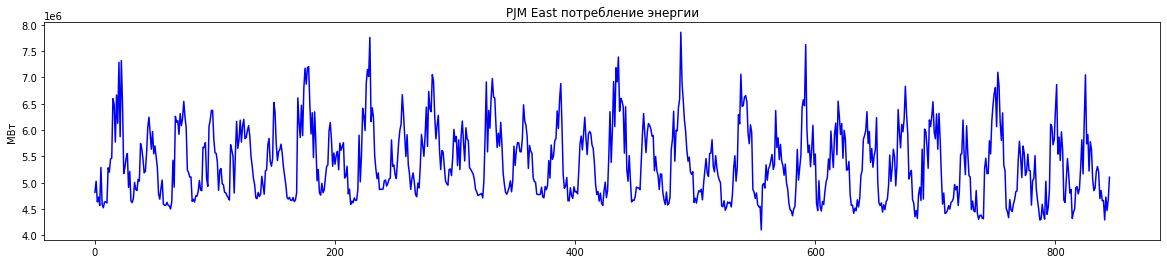

In [7]:
plt.figure(figsize =(20,4))
plt.plot(data_w['PJME_MW'].values[10:-10], 'b' )  #.get_level_values('Date')
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [8]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)
pca_ =PCA(n_components=2)

X = data_w.iloc[:,:].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)
X_p = pca_.fit_transform(Xscale)



C:\Users\vladi\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


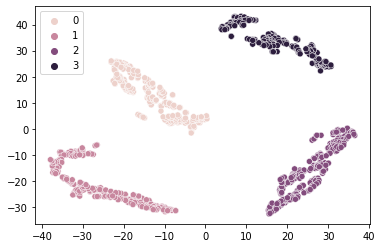

In [9]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

C:\Users\vladi\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


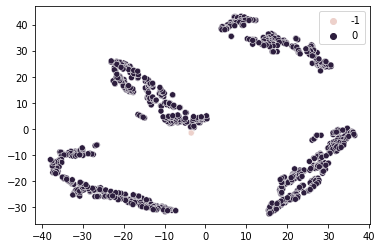

In [10]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

C:\Users\vladi\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


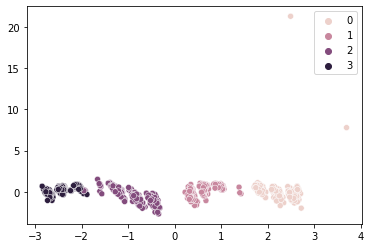

In [11]:
sns.scatterplot(X_p[:,0],X_p[:,1], hue=X_clast)
plt.show()

In [12]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  2
Число кластеров в календаре:  4


In [13]:
data_w['week_month_year'] = X_clast
data_w.iloc[np.where(data_w['week_month_year']==0)[0]].iloc[:10,:]

,PJME_MW,year,month,quarter,weekofyear,week_month_year
Date,,,,,,
2002-01-06,4632079.0,1704,0,0,0,0
2002-01-13,5289881.0,2002,1,1,2,0
2002-01-20,5284084.0,2002,1,1,3,0
2002-01-27,5063777.0,2002,1,1,4,0
2002-02-03,4905010.0,2002,1,1,5,0
2002-02-10,5233287.0,2002,2,1,6,0
2002-02-17,5143583.0,2002,2,1,7,0
2002-02-24,4896214.0,2002,2,1,8,0
2002-03-03,5017994.0,2002,2,1,9,0


In [14]:
data_w.iloc[np.where(data_w['week_month_year']==2)[0]].iloc[:10,:]

,PJME_MW,year,month,quarter,weekofyear,week_month_year
Date,,,,,,
2002-07-07,6489278.0,2002,7,3,27,2
2002-07-14,5772332.0,2002,7,3,28,2
2002-07-21,6664859.0,2002,7,3,29,2
2002-07-28,6128905.0,2002,7,3,30,2
2002-08-04,7285813.0,2002,7,3,31,2
2002-08-11,5873668.0,2002,8,3,32,2
2002-08-18,7318000.0,2002,8,3,33,2
2002-08-25,6473923.0,2002,8,3,34,2
2002-09-01,5173860.0,2002,8,3,35,2
